In [65]:
from scipy.ndimage import gaussian_filter, sobel, median_filter, convolve
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.color import rgb2yuv


In [74]:
GREY = True
YUV = not GREY and True

def rgb2grey(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def read(path):
    img = plt.imread(path)
    if GREY:
        img = rgb2grey(img)
        
    if YUV:
        img = rgb2yuv(img)
    return img

def color_convolve(im1, im2):
    r = convolve2d(im1[:,:,0], im2, 'same')
    g = convolve2d(im1[:,:,1], im2, 'same')
    b = convolve2d(im1[:,:,2], im2, 'same')
    return np.dstack((r,g,b))

def plot_all(list_img):
    n = len(list_img)
    max_y = 3
    
    y = min(max_y, n)
    x = (n // max_y) + 1
    plt.figure(figsize=(12,6))
    
    for i, key in enumerate(list_img):
        tag = f"{x}{y}{i + 1}"
        plt.subplot(tag)
        plt.imshow(list_img[key])
        plt.title(key)

img_j   = read('by_class/4a/hsf_0/hsf_0_00000.png')
license_plate   = read('license_plate.jpg')
# tintin   = read('tintin.jpg')
img_stop = read('stop.png')
flower = read('flower.jpg')


print(img_j.shape)

(128, 128)


(128, 128)


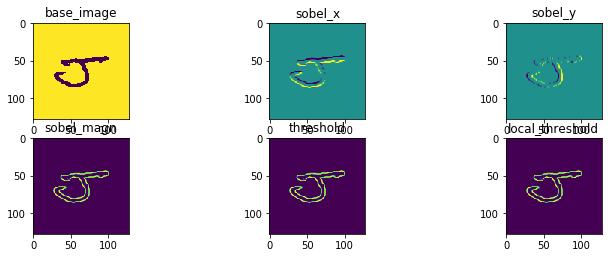

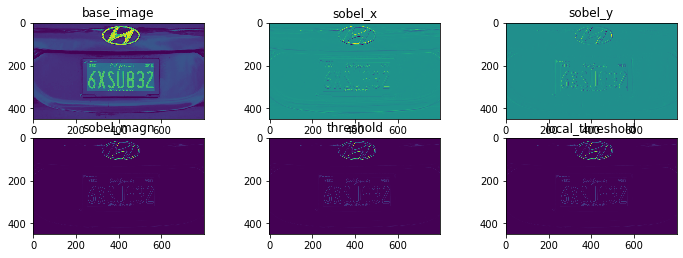

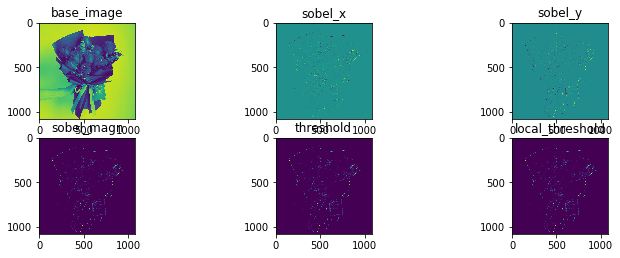

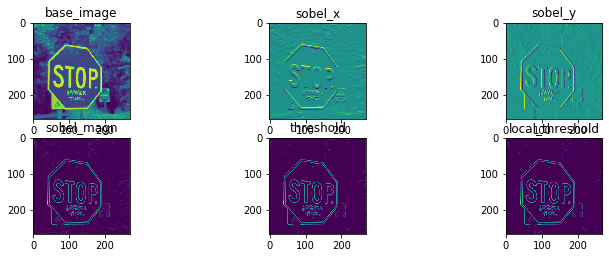

In [78]:
def low_threshold(img):
    # the idea behind this thresholding is that, we expect edges of text to have higher values that edges of background
    # so we take a threshold relative close to edges of text
    thres = np.quantile(img, 0.9)
    
    result = img.copy()
    
    result[result < thres * 0.9] = 0
    
    return result

def local_threshold(img, H, W):
    def simple(window):
        x, y = window.shape[0:2]
        count_blank_line = 0
        for i in range(x):
            if not np.any(window[i,:]):
                count_blank_line += 1

        return count_blank_line > 0.1 * H
    
    def window_threshold_idx(window):
        thres = np.quantile(window, 0.9)
        return np.argwhere(window < thres)
    
    x, y = img.shape[0:2]
    step_x = int(H/2)
    step_y = int(W/2)
    
    marked_points = None
    
    for i in range(0, x, step_x):
        for j in range(0, y, step_y):
            window = img[i: i + H, j: j + W]
            
            if not simple(window):
                marked = window_threshold_idx(window)
                marked_points = np.vstack((marked_points, marked)) if marked_points is not None else marked
    
    results = img.copy()
    for point in marked_points:
        results[tuple(point)] = 0
    return results
        
def edge_detection(img):
    
    sobel_img_x = sobel(img, axis = 0)
    sobel_img_y = sobel(img, axis = 1)
    sobel_img = sobel_img_x ** 2 + sobel_img_y ** 2
    thresh = low_threshold(sobel_img)
    local_thresh = local_threshold(thresh, H=10, W=10)
#     canny = cv2.Canny(img, 100, 200)

    all_plot = {
        "base_image": img,
        "sobel_x": sobel_img_x,
        "sobel_y": sobel_img_y,
        "sobel_magn": sobel_img,
        "threshold": thresh,
        "local_threshold": local_thresh,
#         "canny": canny
    }
    
    
    
    return all_plot

edge_j = edge_detection(img_j)
edge_license_plate = edge_detection(license_plate)
edge_flower = edge_detection(flower)
edge_stop = edge_detection(img_stop)

print(edge_j["local_threshold"].shape)
plot_all(edge_j)
plot_all(edge_license_plate)
plot_all(edge_flower)
# plot_all(edge_detection(tintin))
plot_all(edge_stop)


In [71]:
# Because local thresholding may have decreased the edge density, we apply ESS operator to increase the edge density

def non_zero(matrix):
    return matrix[matrix > 0]

ESS_kernel = 1/220 * np.array([
    [2,4,5,4,2],
    [4,10,20,10,4],
    [5,20,40,20,5],
    [4,10,20,10,4],
    [2,4,5,4,2]
])

ECP_kernel = 1/100 * np.array([
    [8,5,4,5,8],
    [5,2,1,2,5],
    [4,1,0,1,4],
    [5,2,1,2,5],
    [8,5,4,5,8],
])


def text_area_enhancement(img, alpha = 0.5, threshold = 0.7):
    ESS = convolve2d(img, ESS_kernel, 'same') if GREY else color_convolve(img, ESS_kernel)
    zero_points = np.argwhere(ESS == 0)
        
    ECP = convolve2d(ESS, ECP_kernel, 'same') if GREY else color_convolve(img, ESS_kernel)
    for x in zero_points:
        ECP[tuple(x)] = 0
    ECP = np.divide(ECP, ESS, where = ESS!=0)

    EM = alpha * ESS + (1-alpha) * ECP
    
    EM_threshold = EM.copy()
    
    seuil = np.quantile(EM_threshold, 0.9)
#     EM_threshold = low_threshold(EM_threshold, threshold=0.6)
    EM_threshold[EM_threshold < seuil * threshold] = 0
    EM_threshold[EM_threshold > 0] = 1
    
    return {
        "ESS": ESS,
        "ECP": ECP,
        "EM" : EM,
        "EM_binary": EM_threshold
    }

enhance_j = text_area_enhancement(edge_j["local_threshold"])
enhance_license_plate = text_area_enhancement(edge_license_plate["local_threshold"])
enhance_flower = text_area_enhancement(edge_flower["local_threshold"])
enhance_stop = text_area_enhancement(edge_stop["local_threshold"])

plot_all(enhance_j)
plot_all(enhance_license_plate)
plot_all(enhance_flower)
plot_all(enhance_stop)




> <ipython-input-71-42c23ecadf33>(31)text_area_enhancement()
     30         ipdb.set_trace()
---> 31         ECP[tuple(x)] = 0
     32     ECP = np.divide(ECP, ESS, where = ESS!=0)

ipdb> x
array([0, 0, 0])
ipdb> tuple(x)
(0, 0, 0)
ipdb> ECP[tuple(x)]
0.0
ipdb> ECP[x[0], x[1]]
array([0., 0., 0.])
ipdb> ECP(x)
*** TypeError: 'numpy.ndarray' object is not callable
ipdb> ECP[x]
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])
ipdb> exit()


BdbQuit: 